# Sentiment Analysis

## Dependencies

In [1]:
import re

import numpy as np
import pandas as pd

# Visualization
import seaborn as sns

# Google cloud
from google.oauth2 import service_account
from google.cloud import bigquery

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.optimizer_v2.adagrad import Adagrad
from keras.layers import Embedding, Dense, Flatten
from keras.layers.convolutional import Conv1D, AveragePooling1D
from keras.losses import BinaryCrossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models import Word2Vec

import emoji

/home/dionrickysptr/future-data-2/venv/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Loading Data

In [2]:
key_path = '../airflow/credentials/future-data-track-1-sapporo.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bigquery_client = bigquery.Client(
    project='future-data-track-1',
    credentials=credentials
)

In [3]:
query = """
WITH t AS (
  SELECT *
  FROM `future-data-track-1.sapporo_mart.sentiment_analysis`
),
table_stats AS (
  SELECT *, SUM(c) OVER() total 
  FROM (
    SELECT rating, COUNT(*) c 
    FROM t
    GROUP BY 1 
    HAVING c>10000)
)
SELECT sample.*
FROM (
SELECT ARRAY_AGG(a ORDER BY RAND() LIMIT 60000) cat_samples, rating, ANY_VALUE(c) c
FROM t a
JOIN table_stats b
USING(rating)
WHERE sentiment != 1
GROUP BY rating
), UNNEST(cat_samples) sample WITH OFFSET off;
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()

In [4]:
df.head()

,review,rating,sentiment
0,"Sering stuck, lambat & not responding",1,0
1,Saya sangat kecewa pelayan.n cs sangat lama se...,1,0
2,Saat ini mbulet barusan download mau login ver...,1,0
3,Bonus nya modus stiap pesan barang slalu tak s...,1,0
4,Saya peserta prakerja saya telah menyelesaikan...,1,0


In [5]:
df.isna().sum()

review       2
rating       0
sentiment    0
dtype: int64

In [6]:
df = df.dropna(axis=0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239998 entries, 0 to 239999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     239998 non-null  object
 1   rating     239998 non-null  int64 
 2   sentiment  239998 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.3+ MB


### Preprocessing

In [8]:
def extract_emojis(sentence):
    return re.findall(emoji.get_emoji_regexp(), sentence)

In [9]:
def preprocessing_text(texts):
    emojis = extract_emojis(texts)
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    texts = list(filter(lambda x: x, [x.lower() for x in texts.split(" ")]))

    return texts + emojis

In [10]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

In [11]:
df.head()

,review,rating,sentiment,review_cleaned
0,"Sering stuck, lambat & not responding",1,0,"[sering, stuck, lambat, not, responding]"
1,Saya sangat kecewa pelayan.n cs sangat lama se...,1,0,"[saya, sangat, kecewa, pelayan, n, cs, sangat,..."
2,Saat ini mbulet barusan download mau login ver...,1,0,"[saat, ini, mbulet, barusan, download, mau, lo..."
3,Bonus nya modus stiap pesan barang slalu tak s...,1,0,"[bonus, nya, modus, stiap, pesan, barang, slal..."
4,Saya peserta prakerja saya telah menyelesaikan...,1,0,"[saya, peserta, prakerja, saya, telah, menyele..."


In [12]:
word_length = []
for row in df['review_cleaned']:
    word_length.append(len(row))

print(pd.DataFrame(word_length, columns=['word_length']).describe())
print(pd.DataFrame(word_length, columns=['word_length']).quantile(0.90))

         word_length
count  239998.000000
mean       11.043263
std        13.951054
min         0.000000
25%         2.000000
50%         6.000000
75%        15.000000
max       476.000000
word_length    28.0
Name: 0.9, dtype: float64


In [13]:
tokenizer = Tokenizer(num_words=30000)

In [14]:
tokenizer.fit_on_texts(df['review_cleaned'])
seq = tokenizer.texts_to_sequences(df['review_cleaned'])
X = pad_sequences(seq, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (239998, 475), X_min: 0, X_max: 29999


In [15]:
y = df['sentiment'].map({0:0, 2:1})

### Train-test split

In [16]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(153598, 475) (38400, 475) (48000, 475) (153598,) (38400,) (48000,)


## Prepare Embedding

In [17]:
embedding = Word2Vec(df['review_cleaned'], vector_size=100, window=5, workers=2, min_count=2)

In [18]:
words = len(embedding.wv)
print('Vocabulary size: %d' % words)

Vocabulary size: 27960


In [19]:
def get_weight_matrix(embedding: Word2Vec, vocab):
    vocab_size = len(vocab) + 1

    weight_matrix = np.zeros((vocab_size, 100))

    for word, i in vocab.items():
        try:
            weight_matrix[i] = embedding.wv.get_vector(word)
        except:
            continue
    
    return weight_matrix

In [20]:
embedding_vectors = get_weight_matrix(embedding, tokenizer.word_index)

In [21]:
vocab_size = len(tokenizer.word_index) + 1
max_length = X.shape[1]

## Create Model Layers

In [22]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_vectors], input_length=max_length, trainable=True),
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', strides=2),
    AveragePooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', strides=2),
    AveragePooling1D(pool_size=2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 475, 100)          6940200   
_________________________________________________________________
conv1d (Conv1D)              (None, 238, 128)          64128     
_________________________________________________________________
average_pooling1d (AveragePo (None, 119, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 64)            41024     
_________________________________________________________________
average_pooling1d_1 (Average (None, 30, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

## Training Model

In [23]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = Adagrad(learning_rate=0.01)
model.compile(loss=BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/15
4800/4800 [==============================] - 449s 93ms/step - loss: 0.4192 - accuracy: 0.8214 - val_loss: 0.3926 - val_accuracy: 0.8354
Epoch 2/15
4800/4800 [==============================] - 442s 92ms/step - loss: 0.3787 - accuracy: 0.8430 - val_loss: 0.3859 - val_accuracy: 0.8392
Epoch 3/15
4800/4800 [==============================] - 471s 98ms/step - loss: 0.3673 - accuracy: 0.8487 - val_loss: 0.3792 - val_accuracy: 0.8422
Epoch 4/15
4800/4800 [==============================] - 444s 93ms/step - loss: 0.3587 - accuracy: 0.8525 - val_loss: 0.3768 - val_accuracy: 0.8429
Epoch 5/15
4800/4800 [==============================] - 446s 93ms/step - loss: 0.3511 - accuracy: 0.8556 - val_loss: 0.3754 - val_accuracy: 0.8440
Epoch 6/15
4800/4800 [==============================] - 445s 93ms/step - loss: 0.3443 - accuracy: 0.8585 - val_loss: 0.3795 - val_accuracy: 0.8437
Epoch 7/15
4800/4800 [==============================] - 449s 93ms/step - loss: 0.3378 - accuracy: 0.8611 - val_loss: 0

<AxesSubplot:>

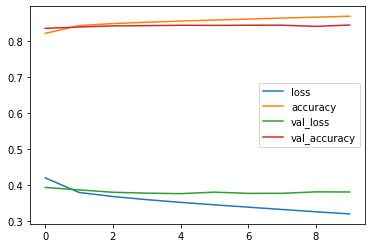

In [24]:
pd.DataFrame(history.history).plot()

              precision    recall  f1-score   support

           0       0.86      0.83      0.85     23800
           1       0.84      0.87      0.85     24200

    accuracy                           0.85     48000
   macro avg       0.85      0.85      0.85     48000
weighted avg       0.85      0.85      0.85     48000



<AxesSubplot:>

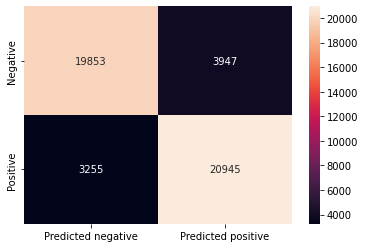

In [25]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

## Serializing Model

In [26]:
MODEL_NAME = 'CNN_Sentiment'
MODEL_VERSION = (4, 0, 'E')
MODEL_DIRNAME = '_'.join([MODEL_NAME, '.'.join(map(str, MODEL_VERSION))])
MODEL_DIRNAME = 'Sentiment Analysis/CNN/' + MODEL_DIRNAME

In [27]:
model.save(MODEL_DIRNAME)

INFO:tensorflow:Assets written to: CNN_Sentiment_4.0.E/assets
